# Inspection of DC2 Run 2.1i Object Table 
### Michael Wood-Vasey (@wmwv)
### Last Verified to Run: 2019-07-22

Inspect the Run 2.1i DR1 Object Table for DR1*

This notebook is more qualitative rather than quantitative validation.  It should eventually grow to include goals for the visualizations and numerical thresholds for specific quantities.

1. Make density plots (e.g., `hexbin`, `hist2d`, `datashader`) of
    - ra, dec
    - u-g, g-r
    - r-i, g-r
    - i-z, g-r
    - z-y, g-r
2. Make 1D density plots (e.g., `hist`, kernel-density-estimation)
    - N({ugrizy})
    - Shape parameters
    
[*] Note that this "DR1" 6-month catalog is actually from months 18-24 of the survey.  For a combination of technical reasons and features of the simulated minion_1016 observing plan, the first 6 months of Year 1 are a very non-representative sample.  We thus provide a DR1 6-month equivalent product that is actually from the second 6 months of Year 2.

#### Run 2.1i includes  
  * 78 million objects  
  * 48 million objects with i-band SNR > 5

Loading the entire catalog takes ~15 minutes, depending on memory load on the JupyterHub node.  We've thus entered an era where it will be common to only look at subsamples of the full DC2 datasets, whether that's considering just one tract, or taking a subsample of the full catalog.

#### Quick Data Size estimates

Loading 1 column stored as 64-bit floats on 64 million objects takes 512 MB of memory:

8 bytes/column/row * 1 column * 64 million rows = 2^3 * 2^0 * 2^6 million bytes (MB) = 2^9 MB = 512 MB

## Import Needed Modules

In [1]:
import math
import os

import numpy as np
from numpy.lib import scimath as SM

import astropy.units as u
import pandas as pd

import GCRCatalogs
from GCR import GCRQuery

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import seaborn as sns

In [3]:
# cmap = 'Oranges'
cmap = 'viridis_r'

## Define Catalog and Subsampling

In [4]:
# For testing one may find it useful to load just one tract:
catalog_name = 'dc2_object_run2.1i_dr1'
# To see the full RA, Dec distribution, load the full catalog.
# Going through whole catalog will take 5-10 minutes to go through each of the files,
# regardless of the subsampling chosen (see next cell)
# catalog_name = 'dc2_object_run2.1i_dr1'

In [5]:
# Sampling must be an positive integer.
# To reduce subsequent arithmetic demands on your brain I would recommend picking a power of ten.
sampling_factor = 10

For further reduction of the sample loaded into the memory we construct  some subsampling filters.
The final digits of the objectId should be evenly distributed across the sample so we can
extract subsample by using modulo to look at last digits.

In [6]:
sampling_factor = int(sampling_factor)
if sampling_factor > 1:
    arbitrary_last_digit = '2'  # If you're really bored, you can explore other choices for the last digit sequence.
    remainder = int(math.ceil(math.log10(sampling_factor)) * arbitrary_last_digit)
    # You can use sampling_factors that are not a power of ten.
    # If you do so, we need to make sure that the remainder is less than the modulus
    remainder = remainder % sampling_factor
    subsample = (lambda x: x % sampling_factor == remainder, 'objectId')
else:
    subsample = None

## Load Data

In [7]:
filters = ('u', 'g', 'r', 'i', 'z', 'y')

In [8]:
cat = GCRCatalogs.load_catalog(catalog_name, config_overwrite={'use_cache': False})

In [9]:
columns = ['ra', 'dec']
columns += [f'mag_{f}' for f in filters]
columns += [f'magerr_{f}' for f in filters]
columns += [f'mag_{f}_cModel' for f in filters]
columns += [f'magerr_{f}_cModel' for f in filters]
columns += [f'Ixx_{f}' for f in filters]
columns += [f'Ixy_{f}' for f in filters]
columns += [f'Iyy_{f}' for f in filters]
columns += [f'psf_fwhm_{f}' for f in filters]
columns += ['good', 'extendedness', 'blendedness']

In [10]:
MB_per_column = 512  # MB / column / 64 million rows
print(f'We are going to load {len(columns)} columns.')
print(f'For {64/sampling_factor} million rows that should take {len(columns)*MB_per_column/sampling_factor/1024} GB of memory')

We are going to load 53 columns.
For 6.4 million rows that should take 2.65 GB of memory


In [11]:
# Select good detections:
#  1. Marked as 'good' in catalog flags.
#  2. SNR in given band > threshold
#  3. In defined simulation range
snr_threshold = 5
snr_filter = 'i'

# We want to do a SNR cut, but magerr is the thing already calculated
# So we'll redefine our SNR in terms of magerr
magerr_cut = (2.5 / np.log(10)) / snr_threshold
quality_cuts = [
    GCRQuery(f'magerr_{snr_filter} < {magerr_cut}'),
]

In [12]:
df = pd.DataFrame(cat.get_quantities(columns, filters=[subsample] + quality_cuts))

In [16]:
print(f'Loaded {len(df)} objects from "{catalog_name}" with a subsampling of {sampling_factor}x')

Loaded 4832794 objects from "dc2_object_run2.1i_dr1" with a subsampling of 10x


#### CosmoDC2

Load CosmoDC2 for reference.  This is the truth table for the input catalog proposals.
It's larger than the Object Table, so we're going to use a similar subsampling plan.

In [17]:
# Need to use 'galaxy_id' instead of 'objectId'
if subsample is None:
    cosmoDC2_subsample = None
else:
    cosmoDC2_subsample = (lambda x: x % sampling_factor == remainder, 'galaxy_id')

In [18]:
cosmoDC2_cat = GCRCatalogs.load_catalog('cosmoDC2', config_overwrite={'use_cache': False})

In [19]:
cosmoDC2_columns = ['ra', 'dec', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y']
max_mag_i = 25
mag_limit_filter = [GCRQuery(f'mag_i < {max_mag_i}')]
cosmoDC2 = pd.DataFrame(cosmoDC2_cat.get_quantities(cosmoDC2_columns,
                                                    filters=[cosmoDC2_subsample] + mag_limit_filter))

In [20]:
print(f'Loaded {len(cosmoDC2)} objects from "cosmocDC2" with a subsampling of {sampling_factor}x')

Loaded 6422263 objects from "cosmocDC2" with a subsampling of 10x


#### HSC XMM
from HSC PDR1.

In [21]:
hsc_cat = GCRCatalogs.load_catalog('hsc-pdr1-xmm',
                                   config_overwrite={'base_dir': '/global/cscratch1/sd/desc/hsc',
                                                    'use_cache': False})

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/GCRCatalogs/dc2_object.py:264: UserWarning: Falling back to reading all datafiles for column names
  warnings.warn('Falling back to reading all datafiles for column names')


In [22]:
# Establish some basic cuts intended to yield a galaxy sample with reasonable flux measurements.
basic_cuts = [
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'),                                      # Flag for bad centroid measurement
]

# Define cuts on galaxy properties: currently we simply make a sample limited at i<25.
# This implicitly requires the magnitude to be finite.
max_mag_i = 25
properties_cuts = [
    GCRQuery(f'mag_i_cModel < {max_mag_i}'),
]

In [23]:
hsc_filters = ['g', 'r', 'i', 'z']
hsc_columns = ['ra', 'dec']
hsc_columns += [f'mag_{f}' for f in hsc_filters]
hsc_columns += [f'magerr_{f}' for f in hsc_filters]
hsc_columns += [f'mag_{f}_cModel' for f in hsc_filters]
hsc_columns += [f'magerr_{f}_cModel' for f in hsc_filters]
# hsc_columns += [f'Ixx_{f}' for f in hsc_filters]
# hsc_columns += [f'Ixy_{f}' for f in hsc_filters]
# hsc_columns += [f'Iyy_{f}' for f in hsc_filters]
# hsc_columns += [f'psf_fwhm_{f}' for f in hsc_filters]
hsc_columns += ['good', 'extendedness', 'blendedness']

In [24]:
hsc = pd.DataFrame(hsc_cat.get_quantities(hsc_columns,
                                          filters=basic_cuts + properties_cuts))

# We could of course done this as part of a GCR query.
# But using a query in the DataFrame is how we did the `stars`, `galaxies` selection above, so we'll do it the same way here.
hsc_stars = hsc[hsc['extendedness'] == 0]
hsc_galaxies = hsc[hsc['extendedness'] > 0]

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/GCRCatalogs/dc2_object.py:392: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/GCRCatalogs/dc2_object.py:392: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


## Object Density in RA, Dec

DC2 Run 2.x WFD and DDF regions
https://docs.google.com/document/d/18nNVImxGioQ3tcLFMRr67G_jpOzCIOdar9bjqChueQg/view
https://github.com/LSSTDESC/DC2_visitList/blob/master/DC2visitGen/notebooks/DC2_Run2_regionCoords_WFD.ipynb

| Location          | RA (degrees) | Dec (degrees) | RA (degrees) | Dec (degrees) |
|:----------------- |:------------ |:------------- |:------------ |:------------- |
| Region            | WFD          | WFD           | DDF          | DDF           |
| Center            | 61.856114    | -35.79        | 53.125       | -28.100       |
| North-East Corner | 71.462228    | -27.25        | 53.764       | -27.533       |
| North-West Corner | 52.250000    | -27.25        | 52.486       | -27.533       |
| South-West Corner | 49.917517    | -44.33        | 52.479       | -28.667       |
| South-East Corner | 73.794710    | -44.33        | 53.771       | -28.667       |

(Note that the order of the rows above is different than in the DC2 papers.  The order of the rows above goes around the perimeter in order.)

In [25]:
dc2_run2x_wfd = [[71.462228, -27.25], [52.250000, -27.25], [49.917517, -44.33], [73.794710, -44.33]]
dc2_run2x_ddf = [[53.764, -27.533], [52.486, -27.533], [52.479, -28.667], [53.771, -28.667]]

In [26]:
def plot_ra_dec(cat, show_dc2_region=True):
    """We're just doing this on a rectilinear grid.
    We should do a projection, of course, but that distortion is minor in this space."""
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_aspect(1)

    plt.hist2d(cat['ra'], cat['dec'], bins=100)
    plt.xlim(plt.xlim()[::-1])  # Flip to East left
    plt.xlabel('RA [deg]')
    plt.ylabel('Dec [deg]')
    plt.colorbar(shrink=0.5, label='objects / bin')

    if show_dc2_region:
        # This region isn't quite a polygon.  The sides should be curved.
        wfd_region = Polygon(dc2_run2x_wfd, color='red', fill=False)
        ddf_region = Polygon(dc2_run2x_ddf, color='orange', fill=False)
        ax.add_patch(wfd_region)
        ax.add_patch(ddf_region)

        max_delta_ra = dc2_run2x_wfd[3][0] - dc2_run2x_wfd[2][0]
        delta_dec = dc2_run2x_wfd[1][1] - dc2_run2x_wfd[3][1]
        grow_buffer = 0.05
        ax.set_xlim(dc2_run2x_wfd[3][0] + max_delta_ra * grow_buffer,
                    dc2_run2x_wfd[2][0] - max_delta_ra * grow_buffer)
        ax.set_ylim(dc2_run2x_wfd[3][1] - delta_dec * grow_buffer,
                    dc2_run2x_wfd[1][1] + delta_dec * grow_buffer)

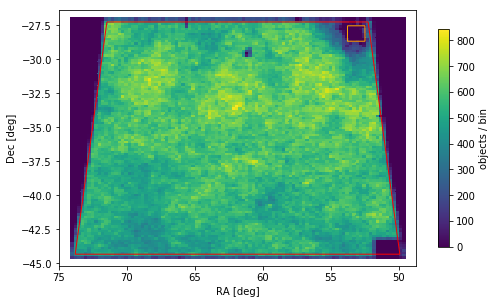

In [27]:
plot_ra_dec(df)

The overall object density distribution looks good.

Notes:
* We're missing the DDF region, which was specifically not included in this DR1 coadd.
* We're missing a bit of the South-West (lower-left, "North Up, East Left") corner.
* There are also a few patches that failed within the main region.
* There is an overall gradient N/S in object density, because we're plotting in rectilinear RA, Dec bins, which means that bins at the bottom in RA cover less area than those at the top.

See the input visit coverage map here:
https://github.com/LSSTDESC/ImageProcessingPipelines/issues/97#issuecomment-498303504


In [28]:
def ellipticity(I_xx, I_xy, I_yy):
    """Calculate ellipticity from second moments.

    Parameters
    ----------
    I_xx : float or numpy.array
    I_xy : float or numpy.array
    I_yy : float or numpy.array

    Returns
    -------
    e, e1, e2 : (float, float, float) or (numpy.array, numpy.array, numpy.array)
        Complex ellipticity, real component, imaginary component
        
    Copied from https://github.com/lsst/validate_drp/python/lsst/validate/drp/util.py
    """
    e = (I_xx - I_yy + 2j*I_xy) / (I_xx + I_yy + 2*SM.sqrt(I_xx*I_yy - I_xy*2))
    e1 = np.real(e)
    e2 = np.imag(e)
    return e, e1, e2

In [29]:
for filt in filters:
    df[f'e_{filt}'], df[f'e1_{filt}'], df[f'e2_{filt}'] = \
    ellipticity(df[f'Ixx_{filt}'], df[f'Ixy_{filt}'], df[f'Iyy_{filt}'])

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/numpy/lib/scimath.py:122: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


In [30]:
def inside_trapezoid(corners, ra, dec):
    # This is a slightly tedious way of defining a symmetric trapezoid
    # Could consider using geopandas, but that adds dependency
    dec_size = corners[1][1] - corners[2][1] # deg

    ra_left_side_delta = corners[1][0] - corners[2][0]
    ra_right_side_delta = corners[0][0] - corners[3][0]
    ra_left_side_slope = ra_left_side_delta / dec_size
    ra_right_side_slope = ra_right_side_delta / dec_size

    inside_ra = (corners[2][0] + ra_left_side_slope * (dec - corners[2][1]) < ra) & \
                (ra < corners[3][0] + ra_right_side_slope * (dec - corners[3][1]))
    inside_dec = (corners[2][1] < dec) & (dec < corners[1][1])

    return inside_ra & inside_dec

In [31]:
inside = inside_trapezoid(dc2_run2x_wfd, df['ra'], df['dec'])
good = df[(df['good']) & inside]

In [32]:
stars = good[good['extendedness'] == 0]
galaxies = good[good['extendedness'] > 0]

In [33]:
print(f'Total: {len(df)}, Good: {len(good)}, Stars: {len(stars)}, Galaxies: {len(galaxies)}')
print(f'For {catalog_name} with {sampling_factor}x subsample')

Total: 4832794, Good: 4682072, Stars: 875860, Galaxies: 3800404
For dc2_object_run2.1i_dr1 with 10x subsample


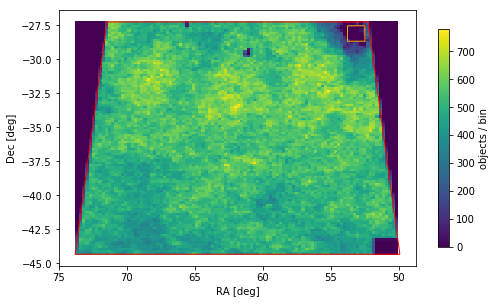

In [34]:
plot_ra_dec(good)

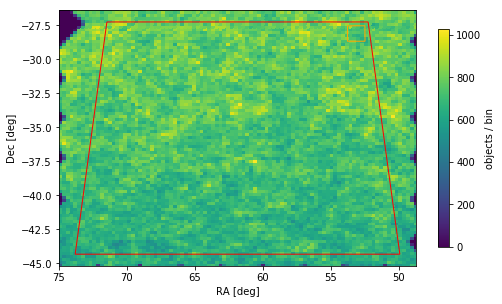

In [35]:
plot_ra_dec(cosmoDC2)

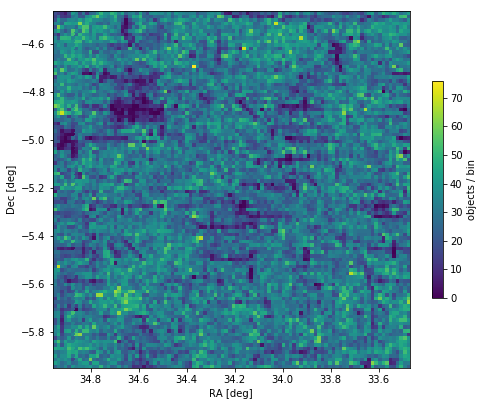

In [36]:
plot_ra_dec(hsc, show_dc2_region=False)

## Color-Color Diagrams and the Stellar Locus

In [37]:
# We refer to a file over in `tutorials/assets' for the stellar locus
datafile_davenport = '../tutorials/assets/Davenport_2014_MNRAS_440_3430_table1.txt'

def get_stellar_locus_davenport(color1='gmr', color2='rmi',
                                datafile=datafile_davenport):
    data = pd.read_table(datafile, sep='\s+', header=1)
    return data[color1], data[color2]

    
def plot_stellar_locus(color1='gmr', color2='rmi',
                       color='red', linestyle='--', linewidth=2.5,
                       ax=None):
    model_gmr, model_rmi = get_stellar_locus_davenport(color1, color2)
    plot_kwargs = {'linestyle': linestyle, 'linewidth': linewidth, 'color': color,
                   'scalex': False, 'scaley': False}
    if not ax:
        ax = fig.gca()

    ax.plot(model_gmr, model_rmi, **plot_kwargs)

In [38]:
def plot_color_color(z, color1, color2, 
                     range1=(-1, +2), range2=(-1, +2), bins=31,
                     ax=None, figsize=(4,4)):
    """Plot a color-color diagram.  Overlay stellar locus"""
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]
    H, xedges, yedges = np.histogram2d(
        z[f'mag_{band1}'] - z[f'mag_{band2}'],
        z[f'mag_{band3}'] - z[f'mag_{band4}'],
        range=(range1, range2), bins=bins)
        
    zi = H.T
    xi = (xedges[1:] + xedges[:-1])/2
    yi = (yedges[1:] + yedges[:-1])/2

    if not ax:
        fig = plt.figure(figsize=figsize)
        ax = fig.gca()

    ax.pcolormesh(xi, yi, zi, cmap=cmap)
    ax.contour(xi, yi, zi)
    ax.set_xlabel(f'{band1}-{band2}')
    ax.set_ylabel(f'{band3}-{band4}')

    try:
        plot_stellar_locus(color1, color2, ax=ax)
    except KeyError as e:
        print(f"Couldn't plot Stellar Locus model for {color1}, {color2}")

In [39]:
def plot_four_color_color(cat):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    colors = ['umg', 'rmi', 'imz', 'zmy']
    ref_color = 'gmr'
    for ax, color in zip(axes.flat, colors):
        try:
            plot_color_color(cat, ref_color, color, ax=ax)
        except KeyError:
            continue

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/ipykernel/__main__.py:6: FutureWarning: read_table is deprecated, use read_csv instead.


Couldn't plot Stellar Locus model for gmr, zmy


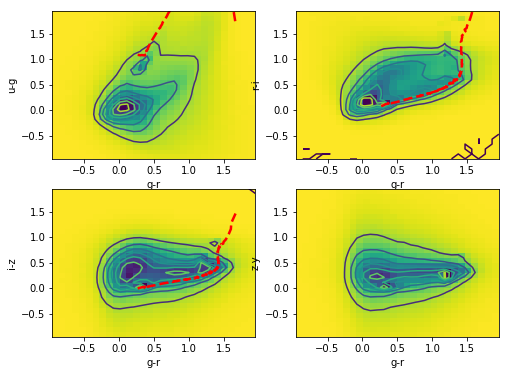

In [40]:
plot_four_color_color(good)

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/ipykernel/__main__.py:6: FutureWarning: read_table is deprecated, use read_csv instead.


Couldn't plot Stellar Locus model for gmr, zmy


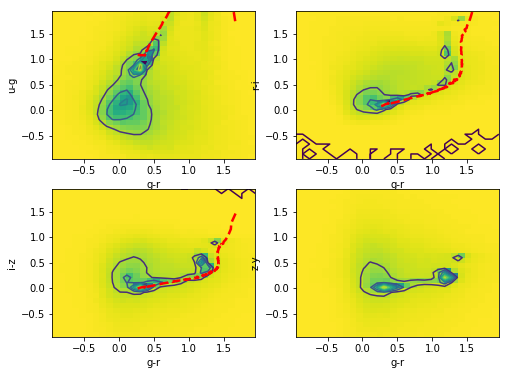

In [41]:
plot_four_color_color(stars)

The discrete islands in the data for stellar color-color plot -- most visible in `r-i` vs. `g-r` at g-r ~= 1.2 mag -- are due to the finite set of stellar models used for simulating M dwarfs.

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/ipykernel/__main__.py:6: FutureWarning: read_table is deprecated, use read_csv instead.


Couldn't plot Stellar Locus model for gmr, zmy


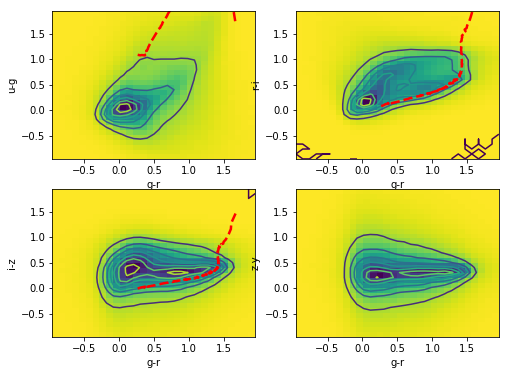

In [42]:
plot_four_color_color(galaxies)

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/ipykernel/__main__.py:6: FutureWarning: read_table is deprecated, use read_csv instead.


Couldn't plot Stellar Locus model for gmr, zmy


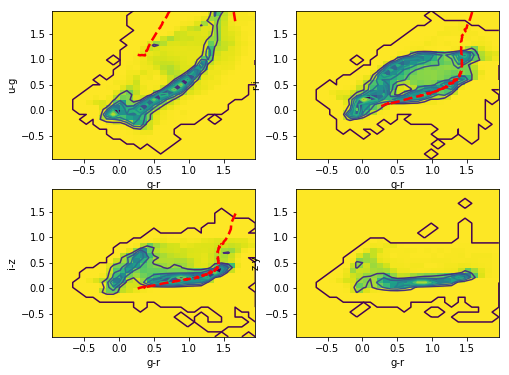

In [43]:
plot_four_color_color(cosmoDC2)

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/ipykernel/__main__.py:6: FutureWarning: read_table is deprecated, use read_csv instead.


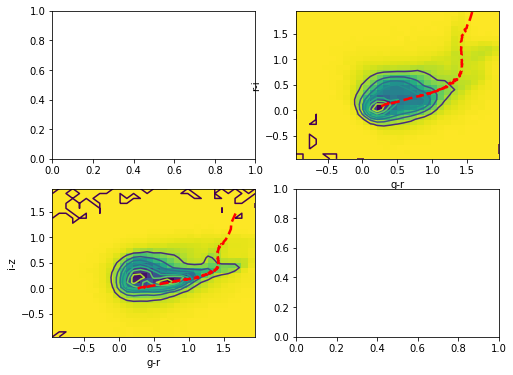

In [44]:
plot_four_color_color(hsc)

Clearly one doesn't expect the galaxies to follow the stellar locus.  The lines above are include to more easily guide the eye between the stars-only and the galaxies-only plots.

Questions for further study:
   1. Is there a better comparison sample for the stellar locus than the Davenport reference?
   2. Why is the stellar locus in the Davenport redder than the observed data.  Are there different extinction assumptions (this should be a low-extinction region).  Are there different bandpasses used?

## 1D Density Plots

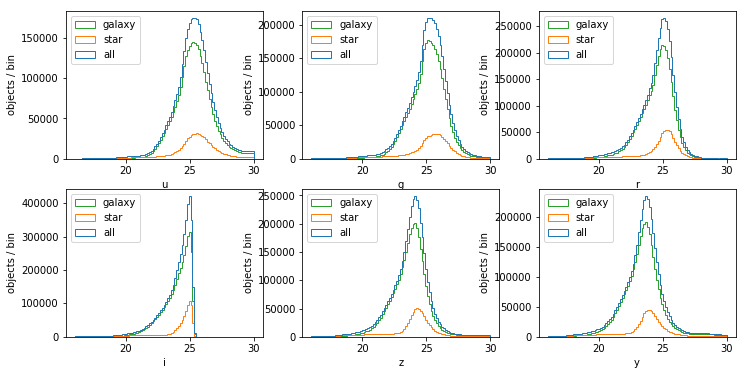

In [45]:
def plot_mag(filt, ax=None):
    if ax is None:
        ax = fig.gca()
    mag = f'mag_{filt}'
    ax.hist([good[mag], stars[mag], galaxies[mag]],
             label=['all', 'star', 'galaxy'],
             range=(16, 30),
             bins=np.linspace(16, 30, 100),
             histtype='step')
    ax.set_xlabel(filt)
    ax.set_ylabel('objects / bin')
    ax.legend(loc='upper left')

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, filt in zip(axes.flat, filters):
    plot_mag(filt, ax=ax)

The sharp cut in i-band is because that was the reference band for most detections.  The u- and y-band distributions extend to 30th because most of them are non-detections.

#### Compare to HSC and CosmocDC galaxy densities

Test inspired by Rachel Mandelbaum

To compare number densities, we have to calculate the area covered by each catalog.
We'll use Healpix through HealPy to pixelate the region and then count of the number of pixels with significant numbers of objects.

In [60]:
def calculate_area(cat, threshold=0.25, nside=1024, verbose=False):
    """Calculate the area covered by a catalog with 'ra', 'dec'
    
    Parameters:
    --
    cat: DataFrame, dict-like with 'ra', 'dec', keys
    threshold:  float
        Fraction of median value required to count a pixel.
    nside:  int
        Healpix NSIDE.  NSIDE=1024 is ~12 sq arcmin/pixel, NSIDE=4096 is 0.74 sq. arcmin/pixel
        Increasing nside will decrease calculated area as holes become better resolved 
        and relative Poisson fluctuations in number counts become more significant.
    verbose:  bool
        Print details on nside, number of significant pixels, and area/pixel.
        
    Returns:
    --
    area:  Astropy Quantity.
    """
    import healpy as hp

    indices = hp.ang2pix(nside, cat['ra'], cat['dec'], lonlat=True)
    idx, counts = np.unique(indices, return_counts=True)
    
    # Take the 25% of the median value of the non-zero counts/pixel
    threshold_counts = threshold * np.median(counts)

    if verbose:
        print(f'Median {np.median(counts)} objects/pixel')
        print(f'Only count pixels with more than {threshold_counts} objects')

    significant_pixels, = np.where(counts > threshold_counts)
    area_pixel = hp.nside2pixarea(nside, degrees=True) * u.deg**2

    if verbose:
        print(f'Pixel size ~ {hp.nside2resol(nside, arcmin=True) * u.arcmin:0.2g}')
        print(f'nside: {nside}, area/pixel: {area_pixel:0.4g}, num significant pixels: {len(significant_pixels)}')

    area = len(significant_pixels) * area_pixel

    if verbose:
        print(f'Total area: {area:0.7g}')
    
    return area

In [61]:
area_dc2 = calculate_area(galaxies)
print(f'DC2 Run 2.1i area: {area_dc2:0.2f}')

DC2 Run 2.1i area: 291.75 deg2


In [62]:
area_hsc = calculate_area(hsc)
print(f'HSC XMM area: {area_hsc:0.2f}')

HSC XMM area: 2.22 deg2


In [63]:
area_cosmoDC2 = calculate_area(cosmoDC2)
print(f'CosmoDC2 area: {area_cosmoDC2:0.2f}')

CosmoDC2 area: 439.86 deg2


In [64]:
num_den_dc2 = sampling_factor * len(galaxies) / area_dc2
num_den_cosmoDC2 = sampling_factor * len(cosmoDC2) / area_cosmoDC2
num_den_hsc = len(hsc) / area_hsc

# Change default expression to 1/arcmin**2
num_den_dc2 = num_den_dc2.to(1/u.arcmin**2)
num_den_hsc = num_den_hsc.to(1/u.arcmin**2)
num_den_cosmoDC2 = num_den_cosmoDC2.to(1/u.arcmin**2)

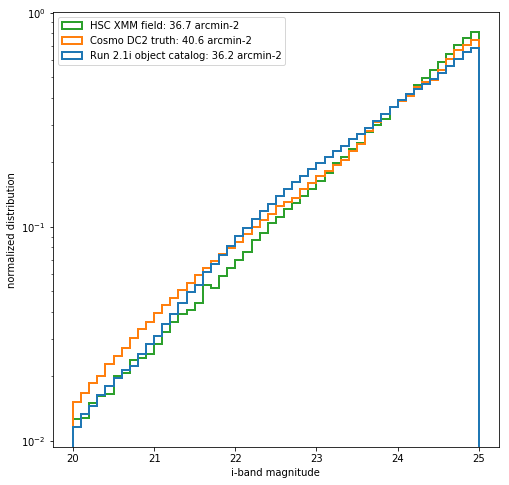

In [65]:
# Now we plot the *normalized* i-band magnitude distributions in Run 2.1i and HSC.
# They are normalized so we can focus on the shape of the distribution.
# However, the legend indicates the total number density of galaxies selected with our magnitude cut,
# which lets us find issues with the overall number density matching (or not).

plt.figure(figsize=(8, 8))
nbins = 50
mag_range = [20, max_mag_i]
data_to_plot = [galaxies['mag_i'], cosmoDC2['mag_i'], hsc['mag_i']]
labels_to_plot = [
    f'Run 2.1i object catalog: {num_den_dc2.value:.1f} {num_den_dc2.unit:fits}',
    f'Cosmo DC2 truth: {num_den_cosmoDC2.value:.1f} {num_den_cosmoDC2.unit:fits}',
    f'HSC XMM field: {num_den_hsc.value:.1f} {num_den_hsc.unit:fits}',
]
plt.hist(data_to_plot, nbins, range=mag_range, histtype='step',
         label=labels_to_plot, linewidth=2.0, density=True)
    
plt.legend(loc='upper left')
plt.xlabel('i-band magnitude')
plt.ylabel('normalized distribution')
plt.yscale('log')
plt.savefig('dc2_object_run2.1i_cosmoDC2_HSC_galaxy_counts.pdf')

## Blendedness

Blendedness is a measure of how much the identified flux from an object is affected by overlapping from other objects.

See Bosch et al., 2018, Section 4.9.11.

In [66]:
w, = np.where(np.isfinite(good['blendedness']))

In [67]:
print(f'{100 * len(w)/len(good):0.1f}% of objects have finite blendedness measurements.')

95.6% of objects have finite blendedness measurements.


Question for futher study:  What happened to yield non-finite blendedness measurements?

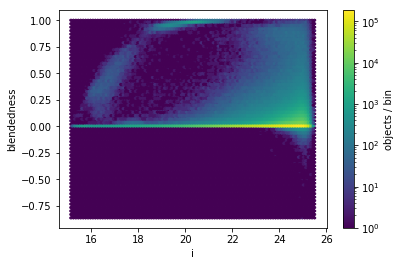

In [68]:
good_blendedness = good[np.isfinite(good['blendedness'])]
plt.hexbin(good_blendedness['mag_i'], good_blendedness['blendedness'],
          bins='log');
plt.xlabel('i')
plt.ylabel('blendedness');
plt.colorbar(label='objects / bin');

### Extendedness
 
Extendedness is essentially star/galaxy separation based purely on morphology in the main detected reference band (which is `i` for most Objects).

Extendedness a binary property in the catalog, so it's either 0 or 1.

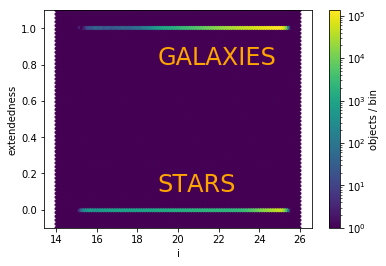

In [69]:
plt.hexbin(good['mag_i'], good['extendedness'],
           extent=(14, 26, -0.1, +1.1),
           bins='log');
plt.xlabel('i')
plt.ylabel('extendedness');
plt.ylim(-0.1, 1.1)
plt.text(19, 0.1, "STARS", fontdict={'fontsize': 24}, color='orange')
plt.text(19, 0.8, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

While the first plot above made extendedness look like a simple binary property, the truth is more complicated.

As galaxies get smaller in angular size and lower in signal-to-noise ratio, it becomes harder to clearly distinguish stars from galaxies.

Extendedness is based off of the difference between the point-source model and extended model brightness.  Specifically objects with `mag_psf - mag_cmodel > 0.164` mag are labeled with `extendedness=1` (i.e., galaxies).

See Bosch et al. 2018, Section 4.9.10 for details.

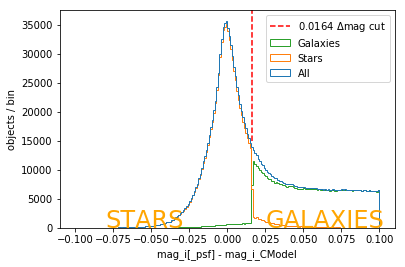

In [70]:
plt.axvline(0.0164, 0.4, 1, color='red', linestyle='--',
           label=r'0.0164 $\Delta$mag cut')  # psf-cModel mag cut from Bosch et al. 2018.

plt.hist([good['mag_i'] - good['mag_i_cModel'],
         stars['mag_i'] - stars['mag_i_cModel'],
         galaxies['mag_i'] - galaxies['mag_i_cModel']],
         label=['All', 'Stars', 'Galaxies'],
         bins=np.linspace(-0.1, 0.1, 201),
         histtype='step')

plt.legend()
plt.xlabel('mag_i[_psf] - mag_i_CModel');
plt.ylabel('objects / bin')

plt.text(-0.080, 100, "STARS", fontdict={'fontsize': 24}, color='orange')
plt.text(+0.025, 100, "GALAXIES", fontdict={'fontsize': 24}, color='orange');

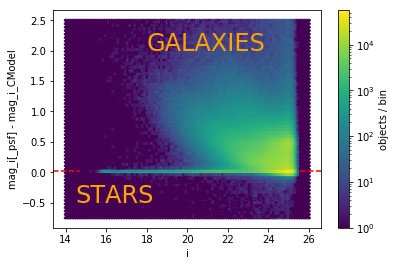

In [71]:
plt.hexbin(good['mag_i'], good['mag_i']-good['mag_i_cModel'],
           extent=(14, 26, -0.75, +2.5),
           bins='log');
plt.xlabel('i')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
plt.text(14.5, -0.5, "STARS", fontdict={'fontsize': 24}, color='orange')
plt.text(18, 2, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

plt.axhline(0.0164, 0.92, 1.0, color='red', linestyle='--')
plt.axhline(0.0164, 0, 0.1, color='red', linestyle='--',
            label=r'0.0164 $\Delta$mag cut');  # psf-cModel mag cut from Bosch et al. 2018.

We can zoom in a little to see how the fixed 0.0164 mag cut works at the low SNR limit.  Specifically at mag 24, we're starting to run out of stars and most things are galaxies.  But that's a population prior, it's not something visible using just morphology information.

You can see the effect of lower SNR measurements as the horizontal line at $\Delta$mag=0 puff up due to increased uncertainties.

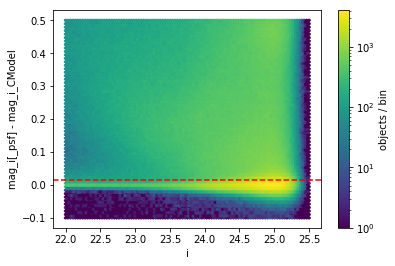

In [72]:
plt.hexbin(good['mag_i'], good['mag_i']-good['mag_i_cModel'],
           extent=(22, 25.5, -0.1, +0.5),
           bins='log');
plt.xlabel('i')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
plt.colorbar(label='objects / bin');

plt.axhline(0.0164, 0, 1, color='red', linestyle='--',
            label=r'0.0164 $\Delta$mag cut');  # psf-cModel mag cut from Bosch et al. 2018.

If we add in color information, 

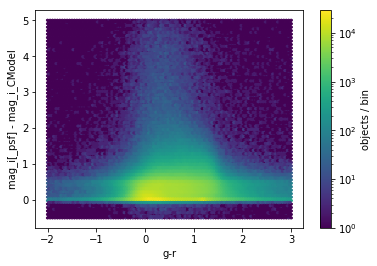

In [73]:
plt.hexbin(good['mag_g'] - good['mag_r'], good['mag_i']-good['mag_i_cModel'],
           extent=(-2, +3, -0.5, +5),
           bins='log');
plt.xlabel('g-r')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
# plt.text(14.5, 0.3, "STARS", fontdict={'fontsize': 24}, color='orange')
# plt.text(18, 2, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

Text(0, 0.5, 'objects / bin')

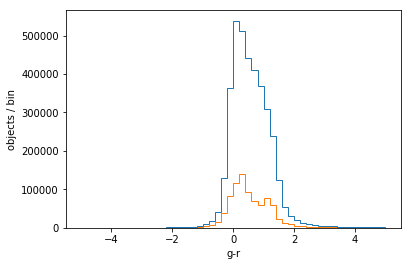

In [74]:
plt.hist([galaxies['mag_g'] - galaxies['mag_r'], stars['mag_g'] - stars['mag_r']],
        label=['galaxies', 'stars'], histtype='step',
        bins=np.linspace(-5, +5, 51));
plt.xlabel('g-r')
plt.ylabel('objects / bin')

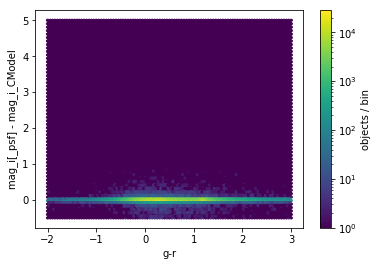

In [75]:
plt.hexbin(stars['mag_g'] - stars['mag_r'], stars['mag_i'] - stars['mag_i_cModel'],
           extent=(-2, +3, -0.5, +5),
           bins='log');
plt.xlabel('g-r')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
# plt.text(14.5, 0.3, "STARS", fontdict={'fontsize': 24}, color='orange')
# plt.text(18, 2, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

## Shape Parameters
Ixx, Iyy, Ixy

In [76]:
def plot_shape(filt, ax=None, legend=True):
    if not ax:
        ax = fig.gca()

    names = ['all', 'star', 'galaxy']
    colors = ['blue', 'orange', 'green']
    hist_kwargs = {'color': colors, 'log': True,
             'bins': np.logspace(-1, 1.5, 100),
             'range': (0, 50),
             'histtype': 'step'}
    for prefix, ls in (('Ixx', '-'), ('Iyy', '--'), ('Ixy', ':')):
        field = f'{prefix}_{filt}'
        labels = [f'{prefix} {name}' for name in names]
        ax.hist([good[field], stars[field], galaxies[field]],
                label=labels,
                linestyle=ls,
                **hist_kwargs)

    ax.set_ylim(100, ax.get_ylim()[1])
    
    ax.set_xlabel(f'{filt}-band Moments: Ixx, Iyy, Ixy [pixels^2]')
    ax.set_ylabel('objects / bin')
    if legend:
        ax.legend()

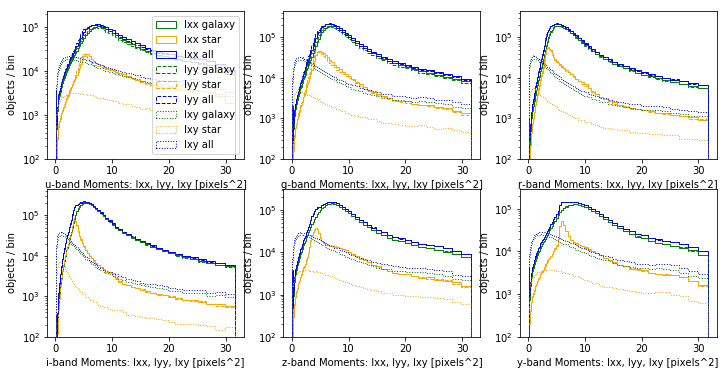

In [77]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
legend = True
for ax, filt in zip(axes.flat, filters):
    plot_shape(filt, ax=ax, legend=legend)
    legend = False

The stars (orange) are concentrated at low values of the source moments.

Would be interesting to
1. Look by magnitude or SNR to undersatnd the longer tail.  Are these galaxies mis-classified as stars, or are these noise sources?
2. Distribution of ellipticity (see validate_drp to type this right)

In [78]:
def plot_ellipticity(good, stars, galaxies, filt, ax=None, legend=True):
    if not ax:
        ax = fig.gca()

    names = ['all', 'star', 'galaxy']
    colors = ['blue', 'orange', 'green']
    hist_kwargs = {'color': colors, 'log': True,
             'bins': np.logspace(-1, 1.5, 100),
             'range': (0, 5),
             'histtype': 'step'}
    for prefix, ls in (('e', '-'), ('e1', '--'), ('e2', ':')):
        field = f'{prefix}_{filt}'
        labels = [f'{prefix} {name}' for name in names]
        ax.hist([good[field], stars[field], galaxies[field]],
                label=labels,
                linestyle=ls,
                **hist_kwargs)

    ax.set_xlim(0, 20)
    ax.set_ylim(10, ax.get_ylim()[1])
    
    ax.set_xlabel(f'{filt}-band ellipticity')
    ax.set_ylabel('objects / bin')
    if legend:
        ax.legend()

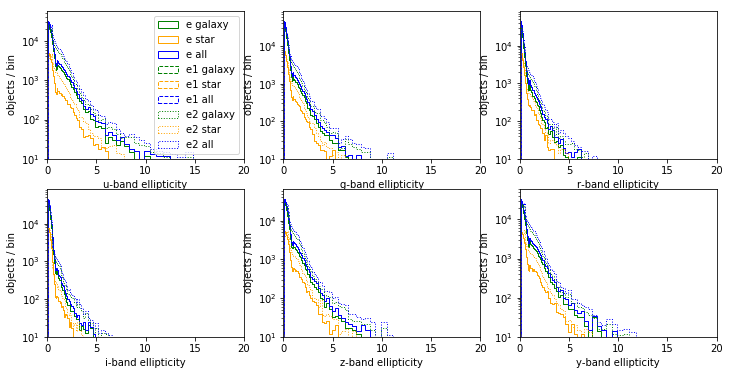

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
legend = True
for ax, filt in zip(axes.flat, filters):
    plot_ellipticity(good, stars, galaxies, filt, ax=ax, legend=legend)
    legend = False

## FWHM

In [80]:
def plot_psf_fwhm(filters=filters,
                 colors=('purple', 'blue', 'green', 'orange', 'red', 'brown')):
    for filt, color in zip(filters, colors):
        psf_fwhm = np.array(good[f'psf_fwhm_{filt}'])
        w, = np.where(np.isfinite(psf_fwhm))
        sns.distplot(psf_fwhm[w], label=filt, color=color)
    plt.xlabel('PSF FWHM [arcsec]')
    plt.ylabel('objects density / bin')
    plt.legend()

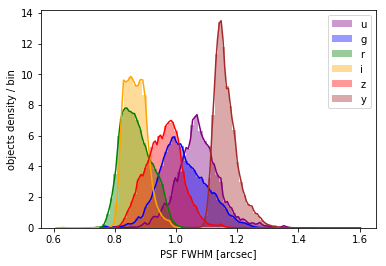

In [81]:
plot_psf_fwhm()